## Information
This notebook is basically a rundown of the entire analysis part of the research. It has been annotated as a sort of "walkthrough" and contains the commands' outputs such that readers can follow along precisely. If you want to play around with pattern matching, `shellbust.ipynb` will be more inviting, as it is much more bare-bones and offers a more direct interface to the core commands. 

In [1]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import random
import numpy as np
from scipy.interpolate import make_interp_spline

In [2]:
def get_raw_data(personalised=False):
    """
    Read .json files and append data to a dict with a key of sessions
    """
    data = {'sessions': []}
    if personalised:
        datadir = "./personalised_data/"
    else:
        datadir = "./data/"

    files = [fname for fname in os.listdir(datadir) if fname.endswith('.json')]
    
    for file in files:
        with open(f"{datadir}{file}", "r") as f:
            js = json.load(f)
            data['sessions'].extend(js['sessions'])
    
    return data

In [3]:
def organize_by_command(data):
    """
    Return a dict where key->command, value->list of list of keystrokes
    """
    commands = defaultdict(list)
    for session in data['sessions']:
        command = session['command']
        keystrokes = session['keystrokes']
        if len(keystrokes) == 0 or len(keystrokes) < len(command):
               continue
        commands[command].append(keystrokes)
    return commands

In [4]:
def zero_first(data):
    """
    Set latency of the first keystroke to zero.
    """
    for cmd in data.keys():
        for session in data[cmd]:
            session[0]['latency'] = 0
    return data

In [5]:
def get_prepared_data(personalised=False):
    """
    Return ordered, zeroed, data dictionary.
    """
    data = get_raw_data(personalised)
    organised = organize_by_command(data)
    zeroed = zero_first(organised)
    return zeroed

In [6]:
def combine_common_tokens(dataset):
    """
    Certain keywords are reused in the dataset. We can combine them for increased coverage.
    i.e. sudo, install, apt, service, etc.
    """
    # We could make this selection automatic via a hashmap, but the idea is that
    # only certain keywords play a big enough role- especially for sudo, which will be an optional
    # prefix for commands to be considered.
    # If we went for all words, then we might as well draw the line at keypair latencies, which is not ideal.

    # A gotcha is that when we train the time forest model, these common tokens need to be set to the same as during evaluation
    common_tokens = set(["sudo", "install", "service", "pacman", "systemctl"])
    aggregated_data = defaultdict(list)

    for command, sessions in dataset.items():
        splices = command.split()
        indices = [0]
        
        # Accumulate indices positions
        for i in range(1, len(splices)):
            # Account for spaces
            indices.append(indices[-1] + len(splices[i-1]) + 1)  

        for i, word in enumerate(splices):
            if word in common_tokens:
                start_idx = indices[i]
                # Not including the space after the word
                end_idx = start_idx + len(word)  

                # Extract the keystrokes corresponding to the word
                keystrokes = [session[start_idx:end_idx] for session in sessions]

                # Zero first latency
                for keystroke in keystrokes:
                    if keystroke:  
                        keystroke[0]['latency'] = 0

                aggregated_data[word].extend(keystrokes)

        # Add the full command data
        aggregated_data[command].extend(sessions)

    return aggregated_data

In [7]:
def handle_backspaces(dataset):
    """
    Account for backspaces in a session by removing the extra keystroke.

    Latencies are not modified, so the latency between a "false" keystroke and the next "correct" keystroke prevails.
    Remains to be seen what the most optimal solution for this is; this seemed to work "okay", however.
    """
    for command in dataset.keys():
        for sequence in dataset[command]:
            i = 0
            while i < len(sequence)-1:
                if sequence[i]['key'] == 'Backspace':
                    curr = sequence[i]
                    prev = sequence[i-1]
                    if i != 0:
                        sequence.remove(prev)
                        sequence.remove(curr)
                        i -= 1
                        continue
                    else:
                        sequence.remove(curr)
                        sequence[i+1]['latency'] = 0
                        continue
                i += 1
    return dataset

In [8]:
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(True)))

In [9]:
len(cmds['systemctl'])

80

In [10]:
# Commands with most sessions in the dataset
sorted(cmds, key=lambda x: len(cmds[x]), reverse=True)

['systemctl',
 'sudo',
 'systemctl status ',
 'cat /etc/resolv.conf',
 'systemctl start ',
 'systemctl stop ',
 'nano ',
 'whoami',
 'sudo su',
 'sudo apt update',
 'iptables -L',
 'cat /etc/passwd',
 'cat /etc/hosts',
 'sudo apt upgrade ',
 'exit',
 'iptables -S',
 'vim ',
 'ifconfig',
 'curl http://',
 'uptime',
 'df -hT /',
 'rm -rf /tmp/*',
 'systemctl restart ',
 'cd',
 'wget https://',
 'id',
 'touch ',
 'ping -c 1 9.9.9.9',
 'tail /var/log/syslog',
 'mv * ../',
 'ss -tuln',
 'netstat -tuln',
 'tar --help']

In [11]:
cmds['ifconfig'][2]

[{'key': 'i', 'latency': 0},
 {'key': 'f', 'latency': 85},
 {'key': 'c', 'latency': 158},
 {'key': 'o', 'latency': 85},
 {'key': 'n', 'latency': 136},
 {'key': 'f', 'latency': 76},
 {'key': 'i', 'latency': 85},
 {'key': 'g', 'latency': 112},
 {'key': 'Return', 'latency': 68}]

In [12]:
cmds = get_prepared_data(personalised=False)


In [13]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [18]:
def plot_command_latencies(keystroke_sequences, command):
    """
    Plot all latencies of a given command together.

    Latency (y) is in milliseconds.
    X-axis shows the keystroke id.
    """
    plt.figure(figsize=(12, 8))
    #plt.figure().set_size_inches(w=6.30045, h=3.6)

    for sequence_idx, sequence in enumerate(keystroke_sequences):
        normal_keys_x = []
        normal_keys_y = []
        backspace_keys_x = []
        backspace_keys_y = []
        
        for keystroke_idx, keystroke in enumerate(sequence):
            if keystroke['key'] == 'Backspace':
                backspace_keys_x.append(keystroke_idx)
                backspace_keys_y.append(keystroke['latency'])
            normal_keys_x.append(keystroke_idx)
            normal_keys_y.append(keystroke['latency'])
                
        # Regular Keystrokes
        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', zorder=1)
        # Backspace Keystrokes
        if backspace_keys_x:
            plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session {sequence_idx + 1} Backspaces', zorder=2)

            
    # custom legend
    keystroke_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='-', label='Keystrokes')
    backspace_handle = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Backspaces')
    
    #plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    #plt.legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    plt.legend(handles=[keystroke_handle, backspace_handle], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    plt.grid(True)
    plt.show()
    #plt.savefig("/tmp/fig.pgf")

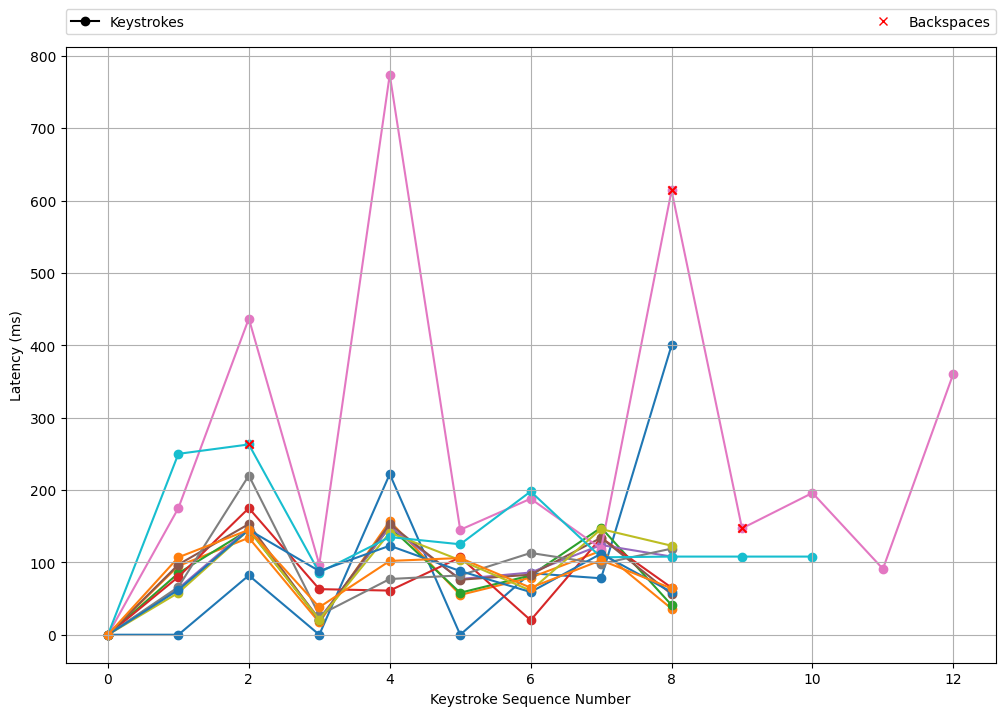

In [19]:
# Load and plot participant dataset without removing backspaces 
cmds = get_prepared_data(personalised=False)
command = "ifconfig"
plot_command_latencies(cmds[command], command)

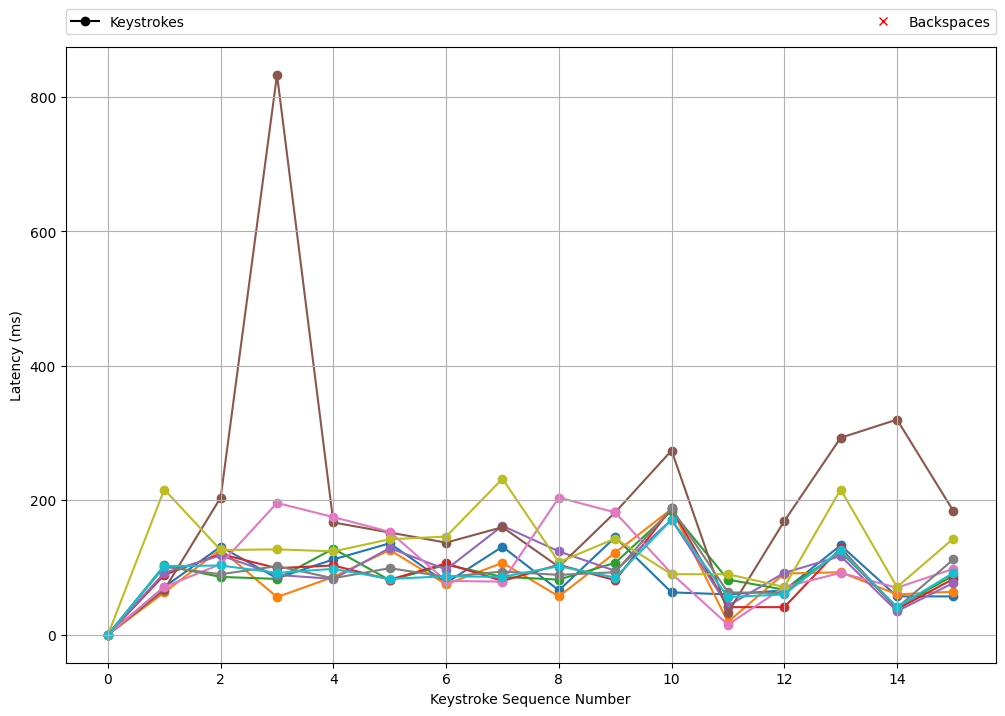

In [20]:
# Load and plot participant without backspaces and with combined tokens 
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(personalised=False)))
command = "sudo apt update"
plot_command_latencies(cmds[command], command)

In [21]:
def plot_command_distribution(keystroke_sequences, command):
    """
    Plot all latencies of a given command together, including the mean latency line.

    Will render an extra phantom-keystroke (return) for keywords taken from tokenisation (combine_common_tokens).

    Note:
        This function contains code generated by ChatGPT. The exact prompt and response are referenced in Appendix B 
        of the project report. 
        GPT was prompted to come up with a way to graph the mean latency trajectory as a smooth red line.
        Its code was not taken verbatim, but the suggested `scipy.interpolate.make_interp_spline` function was used. 
    """
    plt.figure(figsize=(12, 8))
    #plt.figure().set_size_inches(w=6.30045, h=3.6)

    total_latencies = [0] * (len(command) + 1)
    count_per_position = [0] * (len(command) + 1)

    # Plot each keystroke sequence
    for sequence in keystroke_sequences:
        normal_keys_x = []
        normal_keys_y = []
        
        for idx, keystroke in enumerate(sequence):
            normal_keys_x.append(idx)
            normal_keys_y.append(keystroke['latency'])
            if idx < len(total_latencies):
                total_latencies[idx] += keystroke['latency']
                count_per_position[idx] += 1

        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', color='blue', alpha=0.3, zorder=1)
    
    # Calculate mean latencies
    means = [total_latencies[i] / count_per_position[i] if count_per_position[i] else 0 for i in range(len(command)+1)]
    x_new = np.linspace(0, len(command), 300)

    # - taken from ChatGPT -
    # Smoothing the line 
    spl = make_interp_spline(range(len(command)+1), means, k=3)  # BSpline object
    y_smooth = spl(x_new)

    plt.plot(x_new, y_smooth, marker='', linestyle='-', label='Mean keystroke latency', color='red', linewidth=2, zorder=2)
    # - End of Excerpt -
    
    plt.title(f'Mean latencies for command: "{command}"')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(.6, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    #plt.savefig("/tmp/figure.pgf")

In [22]:
len(cmds['sudo apt upgrade '])

0

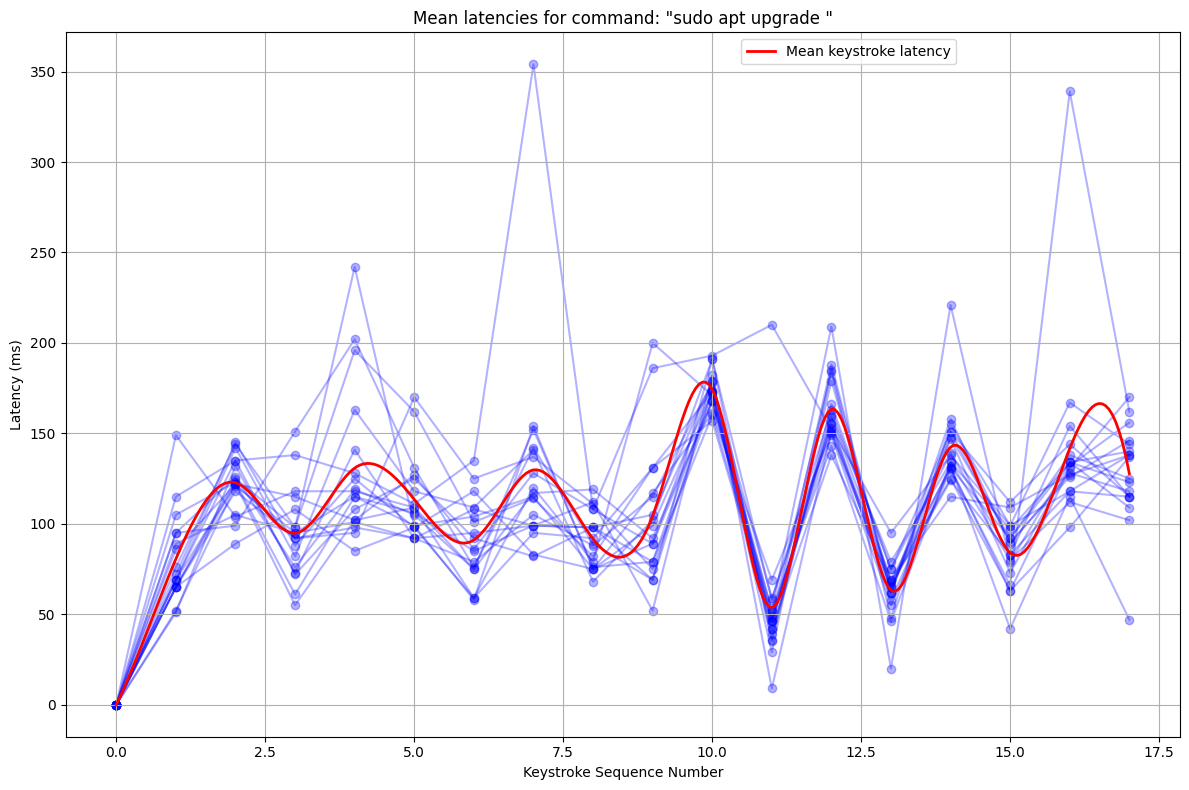

In [23]:
# Load personalised dataset and show distribution for `uptime` 
cmds = combine_common_tokens(handle_backspaces(get_prepared_data(True)))
command = 'sudo apt upgrade '
plot_command_distribution(cmds[command], command)

In [24]:
def load_ssh_session(path, stream=0):
    """
    Load SSHniff session (JSON) output.

    Includes a call to millisecond conversion (!!) 
    By default, assume single-session and get stream automatically.
    """
    stream = str(stream)
    
    with open(path, "r") as f:
        data = json.loads(f.read())
    # SSHniff full output
    if 'keystroke_data' in data[stream]:
        return convert_latencies(data[stream]['keystroke_data'])
    # Only keystroke data (`-k` option)
    return convert_latencies(data[stream])

In [25]:
def convert_latencies(ssh_data):
    """
    Convert latencies from microseconds to milliseconds. 
    """
    for sequence in ssh_data:
        for keystroke in sequence:
            keystroke['timestamp'] = keystroke['timestamp'] / 1000
    return ssh_data

In [26]:
# Load an example SSHniff capture
# The scripts for each capture are stored as follows: ./test_sessions/script_X.txt --> ./test_sessions/capture_X.pcapng
# Here, the following commands were run:
# `uptime`, `ss -tlpn`, `sudo apt update`, `sudo apt upgrade -y`, `iptables -L`, `sudo systemctl restart nginx`, `exit`
ssh_data = load_ssh_session("./sshniff_output/capture_1_sessions.json", 0)

In [31]:
# This is what a captured sequence looks like
ssh_data[-1]

[{'k_type': 'Keystroke', 'timestamp': 0.0, 'response_size': None, 'seq': 5950},
 {'k_type': 'Keystroke',
  'timestamp': 151.993,
  'response_size': None,
  'seq': 5986},
 {'k_type': 'Keystroke',
  'timestamp': 80.254,
  'response_size': None,
  'seq': 6022},
 {'k_type': 'Keystroke',
  'timestamp': 120.023,
  'response_size': None,
  'seq': 6058},
 {'k_type': 'Enter', 'timestamp': 91.674, 'response_size': 176, 'seq': 6130}]

In [13]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

In [29]:
def plot_ssh_latency(sequence):
    """
    Plots SSH keystrokes (unlabelled).

    Y-Axis: Latency (ms)
    X-Axis: Keystroke ID
    """
    plt.figure(figsize=(12, 8))
    #plt.figure().set_size_inches(w=6.30045, h=3.6)
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'])
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'])
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'])
                
    # Regular Keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Backspaces 
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    # Return (Enter)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(.6,1), loc='upper left')
    plt.grid(True)
    plt.show()
    #plt.savefig("/tmp/figure.pgf")

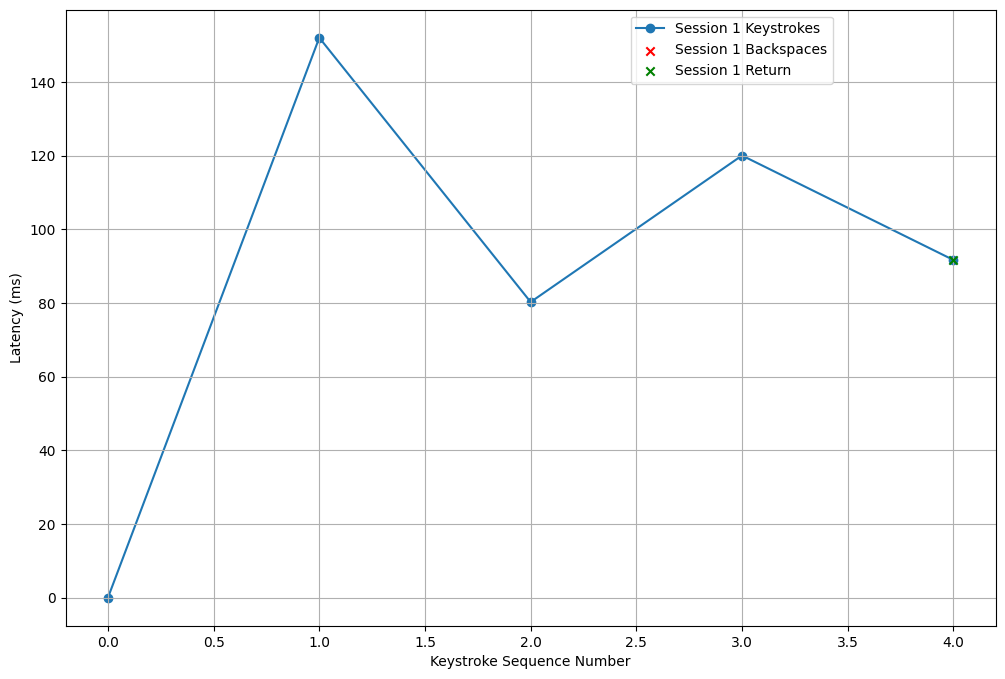

In [33]:
# Visualise intercepted sequence- in this case, `exit`.
plot_ssh_latency(ssh_data[-1])

In [34]:
def plot_ssh_sessions(ssh_sessions):
    """
    Plots SSH sessions 
    """
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(ssh_sessions):
        keystroke_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Keystroke']
        enter_times = [event['timestamp'] for event in sequence if event['k_type'] == 'Enter']
        enter_sizes = [event['response_size'] for event in sequence if event['k_type'] == 'Enter']
        
        # Plot Keystrokes
        plt.plot(keystroke_times, [sequence_idx + 1] * len(keystroke_times), 'bo', label='Keystrokes' if sequence_idx == 0 else "")

        # Plot Enters
        for enter_time, size in zip(enter_times, enter_sizes):
            plt.plot(enter_time, sequence_idx + 1, 'rx', label='Enter Press' if sequence_idx == 0 else "")
            plt.text(enter_time, sequence_idx + 1, f' {size}B', verticalalignment='bottom')

    plt.yticks(range(1, len(ssh_sessions) + 1), [f'Sequence {i+1}' for i in range(len(ssh_sessions))])
    plt.title('Keystroke Timestamps and Returned Data Size')
    plt.xlabel('Time (ms)')
    plt.ylabel('Sequence Number')
    plt.legend()
    plt.grid(True)
    plt.show()

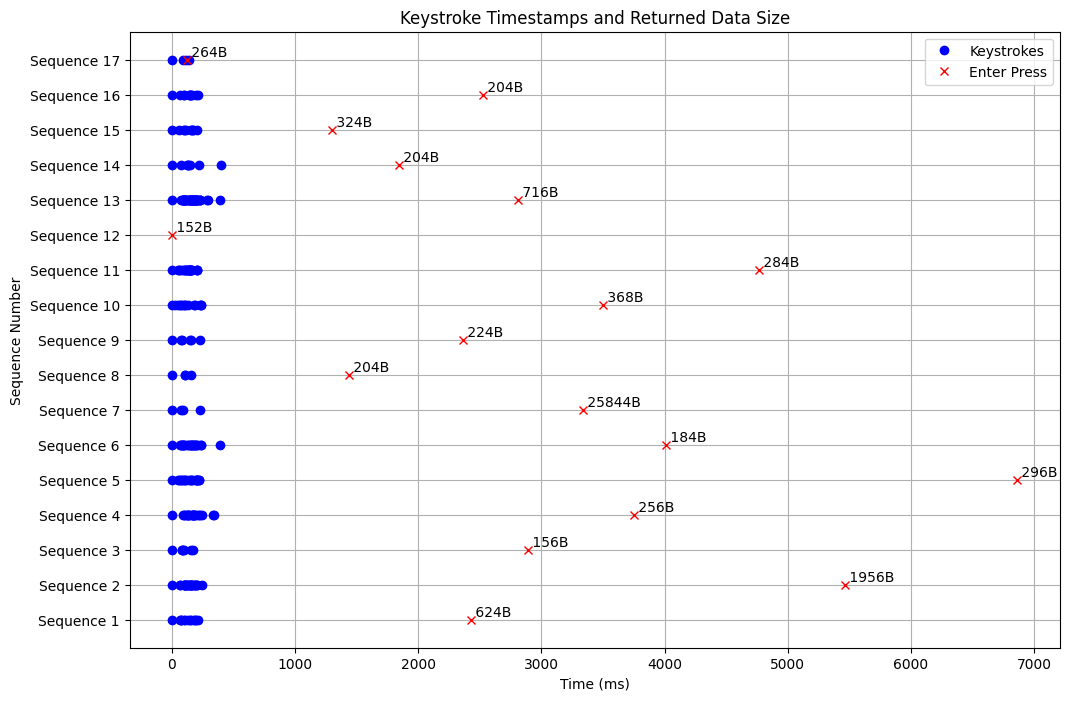

In [35]:
# Show sequences with returned Bytes.
# Works half-well because of the aforementioned <pause> before Enter keystrokes, stretching the image.
ssh_data = load_ssh_session("./sshniff_output/capture_2_sessions.json", 0)
plot_ssh_sessions(ssh_data)

# Time Series Comparison Methods

## Dynamic Time Warping (DTW)

In [36]:
from dtaidistance import dtw
import numpy as np

In [50]:
ssh_data = load_ssh_session("./sshniff_output/capture_1_sessions.json")
cmds = get_prepared_data(True)
cmds = handle_backspaces(cmds)
cmds = combine_common_tokens(cmds)

In [51]:
# Remove RETURN from intercept
for sequence in ssh_data:
    sequence.pop()

In [52]:
def get_mean_latencies(command: str, command_dataset: list):
    """
    Calculates mean latency per keystroke pair for a given command.

    Expects `get_mean_latencies('id', cmds['id'])`
    Ignores RET, unless command has an extra character at the end.
        i.e. "sudo apt update " <--- the space will cause the RET 
        at the end to also be included in the mean latencies.
    Returns a numpy array of the means, with length == len(command).
    """
    means = [0 for i in range(len(command))]
    for letter_index, letter in enumerate(command):
        for sequence in command_dataset:
            means[letter_index] += sequence[letter_index]['latency']
    means = [i / len(command_dataset) for i in means]
    return np.array(means)

In [53]:
command = "ifconfig"
unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in ssh_data[0]])
cmd_mean_latencies = get_mean_latencies(command, cmds[command]) 

In [54]:
[keystroke['timestamp'] for keystroke in ssh_data[4]]

[0.0,
 239.817,
 128.232,
 111.931,
 184.244,
 79.971,
 151.85,
 111.78,
 120.037,
 112.687,
 287.398]

In [55]:
cmd_mean_latencies

array([  0.        ,  75.05882353, 160.11764706,  53.82352941,
       151.23529412,  90.05882353,  86.88235294, 128.        ])

In [56]:
# Normalise intercept and dataset
unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)
known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
# Calculate DTW distance to `iptables -L` mean latencies
distance = dtw.distance(unlabeled_norm, known_norm)
print("DTW Distance:", distance)

DTW Distance: 0.6615048819532802


In [57]:
def eliminate_candidates(intercept_length, command_dataset):
    """
    Reduces the scope of possible commands.

    Using the intercepted command's length, we can exclude commands with 
    a minimum length longer than the intercept. 
        i.e.: A five-letter intercept (XXXXX) cannot be ifconfig, no matter
        how well the signature might match.
    """
    candidates = {}
    for command in command_dataset.keys():
        splices = command.split(' ')
#        if splices[0] == 'sudo':
#            if len(splices[1]) + 5 > intercept_length:
#                # Ignore command if itself 
#                continue
        if len(splices[0]) > intercept_length:
            # Ignore command if it is longer than the intercepted length.
            # i.e., a five-letter intercept cannot be <ifconfig>, no matter how well it matches.
            continue
        else:
            candidates[command] = command_dataset[command]
    return candidates

In [58]:
def find_best_match(intercepted, command_dataset):
    """
    Creates an ordered list of the distance of all possible commands to an intercepted sequence.

    Distance is calculated using Dynamic Time Warping (DTW). 
    """
    unlabeled_latencies = np.array([keystroke['timestamp'] for keystroke in intercepted])
    unlabeled_norm = unlabeled_latencies / np.max(unlabeled_latencies)

    distances = []
    candidates = eliminate_candidates(len(intercepted), command_dataset)
    for command in candidates.keys():
        try:
            cmd_mean_latencies = get_mean_latencies(command, command_dataset[command])
        except:
            print(f"failed at {command}")
            continue
        known_norm = cmd_mean_latencies / np.max(cmd_mean_latencies)
        distance = dtw.distance(unlabeled_norm, known_norm)
        distances.append((command, distance))

    distances = sorted(distances, key=lambda x: x[1])
    return distances

In [59]:
# ssh_data[0] is `uptime`, DTW matches it pretty well
# (We are using the personalised dataset here)
[find_best_match(ssh_sequence, cmds)[:3] for ssh_sequence in ssh_data]

[[('uptime', 0.18402696246224298),
  ('exit', 0.24952838072909067),
  ('sudo su', 0.4514185096253787)],
 [('whoami', 0.2828471233800584),
  ('tar --help', 0.3384632894428777),
  ('ss -tuln', 0.34936522532801295)],
 [('sudo apt update', 0.42198853595684865),
  ('cat /etc/passwd', 0.5534998830683161),
  ('tail /var/log/syslog', 0.5552429493053848)],
 [('sudo apt upgrade ', 0.5618888750262606),
  ('ping -c 1 9.9.9.9', 0.7192088847887899),
  ('ifconfig', 0.7286767130903334)],
 [('iptables -L', 0.2634720609858176),
  ('iptables -S', 0.3045489458689891),
  ('whoami', 0.31624386127485116)],
 [('systemctl start ', 0.6852641581843808),
  ('systemctl restart ', 0.7137367775894122),
  ('sudo apt update', 0.7217817717178643)],
 [('exit', 0.08008537849140958),
  ('ss -tuln', 0.2980634997662481),
  ('sudo', 0.3946081612607259)]]

In [60]:
# ssh_data[1] is `ss -tlpn`, third choice is `ss -tuln`.
find_best_match(ssh_data[1], cmds)[:3]

[('whoami', 0.2828471233800584),
 ('tar --help', 0.3384632894428777),
 ('ss -tuln', 0.34936522532801295)]

In [61]:
# ssh_data[2] is `sudo apt update`, which is DTW's top match.
find_best_match(ssh_data[2], cmds)[:3]

[('sudo apt update', 0.42198853595684865),
 ('cat /etc/passwd', 0.5534998830683161),
 ('tail /var/log/syslog', 0.5552429493053848)]

In [62]:
# Let's see what happens if we isolate the `sudo` keystrokes from that previous command. 
sudo = ssh_data[2][:5]
find_best_match(sudo, cmds)[:5]

[('rm -rf /tmp/*', 0.3245931370304874),
 ('vim ', 0.3282873899979708),
 ('nano ', 0.35859296184932715),
 ('sudo', 0.38608444644665585),
 ('cd', 0.39917080718622977)]

# Hidden Markov Model Experimentation

In [63]:
with open("./commands.json", "r") as f:
    commands = json.load(f)

In [64]:
s_cmds = []
for category in commands['commands']:
    s_cmds.extend(category['patterns'])
s_cmds.extend(commands['commonFlags'])
s_cmds.extend(commands['commonPathStarts'])

In [65]:
char_pairs = set()

for cmd in s_cmds:
    for i in range(len(cmd) - 1):
        pair = cmd[i:i+2]
        char_pairs.add(pair)

In [66]:
len(char_pairs)

296

In [67]:
def get_minlen(command: str) -> int:
    # How do we reliably determine minimum length?
    # Split at first ' ' doesn't cover cmds like 'cp src dst' but it is a start.
    splice = command.split(" ", 1)[0]
    return len(splice)

In [68]:
def get_charpairs(command: str) -> (str, set()):
    if len(command) < 2:
        return
    first = set([command[:2]])
    rest = set()
    for i in range(1, len(command)-1):
        rest.add(command[i:i+2])
    return [first, rest]

In [69]:
# This one doesn't make much sense. Each start state can only logically produce certain following states, so it doesn't make sense to pool them by length
def make_state_objects(commands: list):
    # minlen -> (startstates, states)?
    state_objects = {}
    # (minlen, startstate, states)
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_charpairs(command)
        if not pairs:
            continue
        if minlen in state_objects:
            state_objects[minlen][0] = state_objects[minlen][0].union(pairs[0])
            state_objects[minlen][1] = state_objects[minlen][1].union(pairs[1])
        else:
            state_objects[minlen] = pairs
    return state_objects

In [70]:
def get_pairs(command: str):
    pairs = []
    for i in range(len(command) - 1):
        pair = command[i:i+2]
        pairs.append(pair)
    return pairs

In [71]:
def make_len_map(commands: list):
    # minlen -> [["if", "fc", "co", "on", "nf", "fi", "ig"], ...]
    lenmap = {}
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_pairs(command)
        if not pairs:
            continue
        if minlen in lenmap:
            lenmap[minlen].append(pairs)
        else:
            lenmap[minlen] = [pairs]
    return lenmap

In [72]:
mp = make_len_map(s_cmds)

## KeyRecs dataset
Download: https://zenodo.org/records/7886743  
Citation:  
```
Tiago Dias, João Vitorino, Eva Maia, Orlando Sousa, Isabel Praça,
KeyRecs: A keystroke dynamics and typing pattern recognition dataset,
Data in Brief,
Volume 50,
2023,
109509,
ISSN 2352-3409,
https://doi.org/10.1016/j.dib.2023.109509.
(https://www.sciencedirect.com/science/article/pii/S2352340923006091)
```

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
df = pd.read_csv('./keyrecs_dataset/free-text.csv', index_col=0)

/tmp/ipykernel_7959/2388355099.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./keyrecs_dataset/free-text.csv', index_col=0)


In [77]:
# A lot of undesirable keys are contained.
# These are not transmitted via SSH, or not relevant to our research.
df = df[["key1", "key2", "DD.key1.key2"]]
bad_keys = ["Shift", "Control", "Alt", "CapsLock", "MediaTrackNext", "Dead", "End", "Insert", "OS", "Meta", "AltGraph", "AudioVolumeDown", ",0.134,0.281,0.502,0.147,0.368,\np037,2,", ",0.096,0.8,0.896,0.704,0.8,\np087,1,"]
df = df[~df['key1'].isin(bad_keys) & ~df['key2'].isin(bad_keys)]
# Remove outliers in terms of latency.
# There are thousands of rows with latencies above 1000 seconds.
# We remove all those that have negative latencies or >3 seconds
df = df[df['DD.key1.key2'] > 0]
df = df[df['DD.key1.key2'] < 3]

In [78]:
df

,key1,key2,DD.key1.key2
participant,,,
p001,e,Space,0.172
p001,Space,b,0.200
p001,b,e,0.320
p001,e,l,1.432
p001,l,i,0.280
...,...,...,...
p100,Space,s,0.114
p100,s,t,0.120
p100,t,a,0.092


In [79]:
df['keypair'] = list(zip(df['key1'], df['key2']))

In [80]:
unique_pairs = df['keypair'].dropna().unique()
u = set(tuple(pair) for pair in unique_pairs)

In [81]:
grouped = df.groupby('keypair')['DD.key1.key2'].agg(list).reset_index()

In [82]:
def plot_latency_distribution(grouped_data, char_pair1, char_pair2=None):
    """
    Plots the latency distribution for the specified character pairs.
    
    Args:
    grouped_data (DataFrame): DataFrame with character pairs and their latencies.
    char_pair1 (tuple): First character pair to plot the distribution for.
    char_pair2 (tuple, optional): Second character pair to plot the distribution for, plotted in red if provided.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot for first character pair
    data1 = grouped_data[grouped_data['keypair'] == char_pair1]['DD.key1.key2'].values[0]
    sns.histplot(data1, kde=True, color="blue", bins=30, label=f'Pair {char_pair1}')

    # Plot for second character pair if provided
    if char_pair2:
        data2 = grouped_data[grouped_data['keypair'] == char_pair2]['DD.key1.key2'].values[0]
        sns.histplot(data2, kde=True, color="red", bins=30, label=f'Pair {char_pair2}')

    plt.title(f'Latency Distribution for Pairs {char_pair1}' + (f' and {char_pair2}' if char_pair2 else ''))
    plt.xlabel('Latency (seconds)')
    plt.ylabel('Frequency')
    plt.legend(title='Character Pairs')
    plt.show()

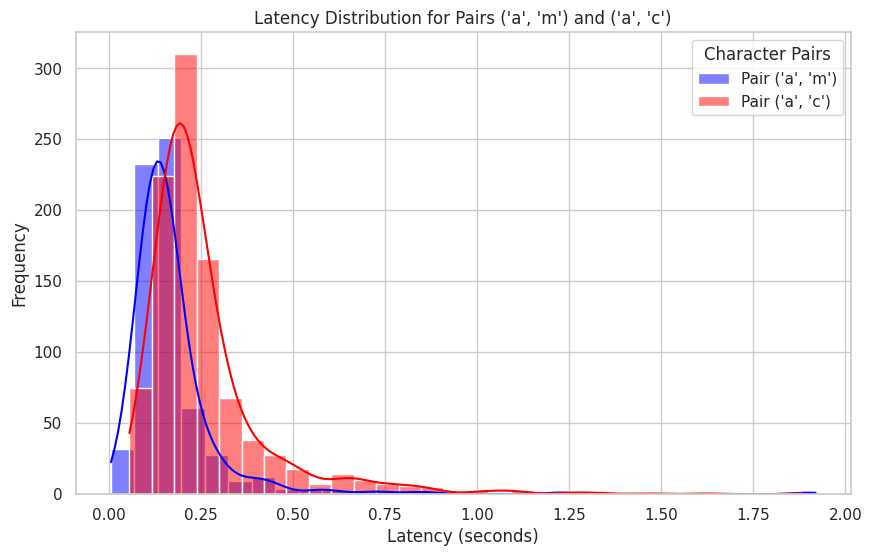

In [83]:
pair = ('a', 'm')
plot_latency_distribution(grouped, pair, ('a','c'))

# Decision Trees

In [84]:
ssh_data = load_ssh_session("./sshniff_output/capture_1_sessions.json")
cmds = get_prepared_data(False)
cmds = handle_backspaces(cmds)
cmds = combine_common_tokens(cmds)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from tsfresh.feature_extraction import ComprehensiveFCParameters, extract_features
from tsfresh.utilities.dataframe_functions import impute
import pandas as pd

In [86]:
def extract_tsf_features(latency_sequences):
    """
    Extracts time series features from latency sequences using tsfresh.
    """
    # https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html
    extracted_features = extract_features(latency_sequences, column_id="id", column_sort="time", 
                                          default_fc_parameters=ComprehensiveFCParameters(), impute_function=impute)
    return extracted_features

def create_feature_matrix(commands):
    """
    Constructs a feature matrix for all commands' latency sequences.
    """
    all_features = []
    labels = []
    command_ids = {cmd: idx for idx, cmd in enumerate(commands.keys())}
    
    for command, sequences in commands.items():
        print(f"{command=}")
        for sequence in sequences:
            data = {'id': [], 'time': [], 'value': []}
            for time_point, entry in enumerate(sequence):
                data['id'].append(command_ids[command])
                data['time'].append(time_point)
                data['value'].append(entry['latency'])
            df = pd.DataFrame(data)
            features = extract_tsf_features(df)
            all_features.append(features)
            labels.append(command_ids[command])
    
    return pd.concat(all_features), np.array(labels)

In [ ]:
# For each sequence in each command in the Participant dataset, we create a feature set.
# All features are then concatenated into a pandas object. (Xi_train)
# yi_train contains the indeces that convey which feature set(s) correspond to which command.
# This is resource-intensive, so to load the saved features instead, scroll further down.
X2_train, y2_train = create_feature_matrix(cmds)
X2_train.to_csv("./xtrain_participants.csv")
y2_train

In [138]:
y2_train

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20

In [ ]:
# We do the same with the personalised dataset.
X_train, y_train = create_feature_matrix(cmds)

In [25]:
X_train.to_csv("./xtrain.csv")

In [29]:
y_train

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [235]:
# Since calculating the feature sets is very resource-intensive, we did that once and then saved
# them to a file for easier loading. 
X_train_participants = pd.read_csv("./xtrain_participants.csv").drop('Unnamed: 0', axis=1)
y_train_participants = np.array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26,
       26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34,
       34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37,
       38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42,
       42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 50, 50, 50, 50, 50, 51,
       51, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54,
       54, 54, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56,
       56, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 59, 59, 59, 59, 59,
       59, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62,
       62, 62, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 65,
       65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67,
       67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 69, 69, 70, 70, 70, 70, 71,
       71, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 74, 74, 75, 75, 75,
       75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 78,
       78, 78, 79, 79, 79, 79, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83])

In [236]:
X_train = pd.read_csv("./xtrain.csv").drop('Unnamed: 0', axis=1)
y_train = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31,
       31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])

In [241]:
# Here we can see what this feature set actually looks like.
X_train_participants

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,252.0,22106.0,57.666667,29.000000,-19.500000,74.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,1.0,0.0,0.0,0.0,341.0,40627.0,62.333333,35.666667,-31.750000,97.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,1.0,0.0,0.0,0.0,185.0,13009.0,44.000000,18.000000,-19.250000,46.0,...,0.636514,0.636514,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,1.0,0.0,0.0,0.0,362.0,46850.0,52.333333,46.333333,-21.000000,107.0,...,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,1.0,0.0,0.0,0.0,290.0,28494.0,47.666667,27.666667,-31.000000,88.5,...,0.636514,0.636514,1.098612,0.693147,-0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,1.0,0.0,0.0,0.0,4692.0,2306878.0,247.230769,24.615385,-0.291667,255.0,...,1.494175,1.667462,2.079442,1.424130,2.019815,2.302585,2.197225,2.079442,0.0,506.000000
675,1.0,0.0,0.0,1.0,1522.0,203606.0,61.538462,7.076923,-2.500000,102.0,...,1.213008,1.732868,2.079442,1.589027,2.271869,2.302585,2.197225,2.079442,0.0,146.857143
676,1.0,0.0,0.0,0.0,2174.0,1470570.0,332.250000,148.250000,-106.333333,350.0,...,1.098612,1.098612,1.098612,0.636514,0.693147,-0.000000,0.000000,0.000000,0.0,0.000000
677,1.0,0.0,0.0,0.0,545.0,77199.0,56.500000,39.500000,-11.000000,129.0,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,0.000000,0.000000,0.0,0.000000


In [244]:
from sklearn.ensemble import RandomForestClassifier

def train_tsf(X, y):
    """
    Trains a Time Series Forest model.
    """
    # n_estimators is the number of trees in the forest. 
    # 100 is the default.
    # According to the docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    #     "To obtain a deterministic behaviour during fitting, random_state has to be fixed."
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

In [246]:
# Create a model using the participant dataset
model = train_tsf(X_train_participants, y_train_participants)

In [247]:
def predict_command(model, new_sequence):
    """
    Predicts the command type from a new latency sequence using the trained TSF model.
    """
    new_features = extract_tsf_features(new_sequence)
    prediction = model.predict(new_features)
    return prediction

In [86]:
ssh_data = convert_latencies(load_ssh_session("./sshniff_output/capture_1_ssh_session.json"))

In [87]:
for sequence in ssh_data:
    sequence.pop()

In [88]:
intercepted_latencies = [k['timestamp']*1000 for k in ssh_data[6]]

In [89]:
new_sequence = {'id': [0] * len(intercepted_latencies), 'time': list(range(len(intercepted_latencies))), 'value': intercepted_latencies}

In [90]:
new_sequence

{'id': [0, 0, 0, 0],
 'time': [0, 1, 2, 3],
 'value': [0.0, 151.993, 80.254, 120.023]}

In [91]:
prediction = predict_command(model, pd.DataFrame(new_sequence))

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


In [92]:
prediction[0]

30

In [93]:
list(cmds.keys())[30]

'-al'

In [101]:
# https://stackoverflow.com/a/63123665
probs = model.predict_proba(extract_tsf_features(pd.DataFrame(new_sequence)))
predictions = model.classes_[np.argsort(probs)[:, :-3 - 1:-1]]
assert len(probs) == len(predictions)
prediction1 = [preds[0] for preds in predictions]
prediction2 = [preds[1] for preds in predictions]
prediction3 = [preds[2] for preds in predictions]
top1prob = [ probs[i][prediction1[i]] for i in range(len(predictions))]
top2prob = [ probs[i][prediction2[i]] for i in range(len(predictions))] 
top3prob = [ probs[i][prediction3[i]] for i in range(len(predictions))]

Feature Extraction: 100%|██████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


In [94]:
probs = model.predict_proba(extract_tsf_features(pd.DataFrame(new_sequence)))
predictions = model.classes_[np.argsort(probs)[:, ::-1]]
for pred in predictions[0][:10]:
    command = list(cmds.keys())[pred]
    print(f"Prediction: {command} ; {probs[0][pred]}")

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]

Prediction: -al ; 0.9
Prediction: sudo ; 0.08
Prediction: exit ; 0.01
Prediction: -v ; 0.01
Prediction: cd ~ ; 0.0
Prediction: yum install package ; 0.0
Prediction: dd if=/dev/zero of=file bs=1M count=10 ; 0.0
Prediction: pip3 install package ; 0.0
Prediction: tar -czvf archive.tar.gz directory ; 0.0
Prediction: awk '/pattern/ {action}' file ; 0.0


In [34]:
import shap

C:\Users\Asus\Documents\Coding\kanalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
shap.initjs()

In [36]:
explainer = shap.TreeExplainer(model)

In [42]:
features = extract_tsf_features(pd.DataFrame(new_sequence))

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


In [55]:
features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,1151.774,199385.177104,68.062714,31.969,-7.861167,159.0585,...,1.332179,1.332179,1.609438,1.098612,1.332179,1.386294,1.098612,0.693147,0.0,164.539143


In [43]:
shap_values = explainer(features)

In [60]:
type(shap_values[0])

shap._explanation.Explanation

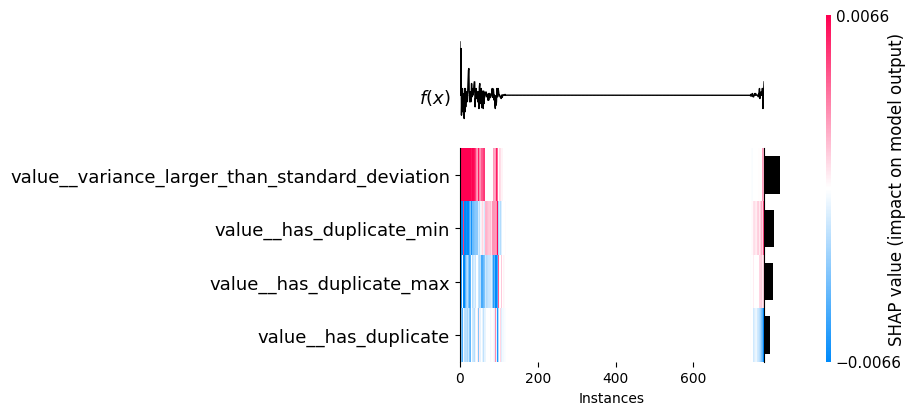

In [91]:
shap.plots.heatmap(shap_values[3])

# Patch Analysis

### patch3.pcapng

In the first capture (patch3), we ran `uptime`, followed by `exit`, in a "normal" fashion, with no intentional delays.

While all keystrokes (both fake and real) were captured successfully, the return keystroke was swallowed up somewhere, and could not be discerned by the current implementation.

However, the inherent characteristics of packet sizings seemed to prevail (judging by Wireshark), so in the next capture, we added a delay before pressing Return. 

In [36]:
patch3 = load_ssh_session("./sshniff_output/patch3_uptime_exit_sessions.json", 2)

As alluded to above, in `patch3` our return was swallowed up somewhere along the line, likely because the fake keystrokes were enough in size to contain the response data without requiring consecutive server-side packets.

However, we notice a massive spike somewhere along the keystrokes.

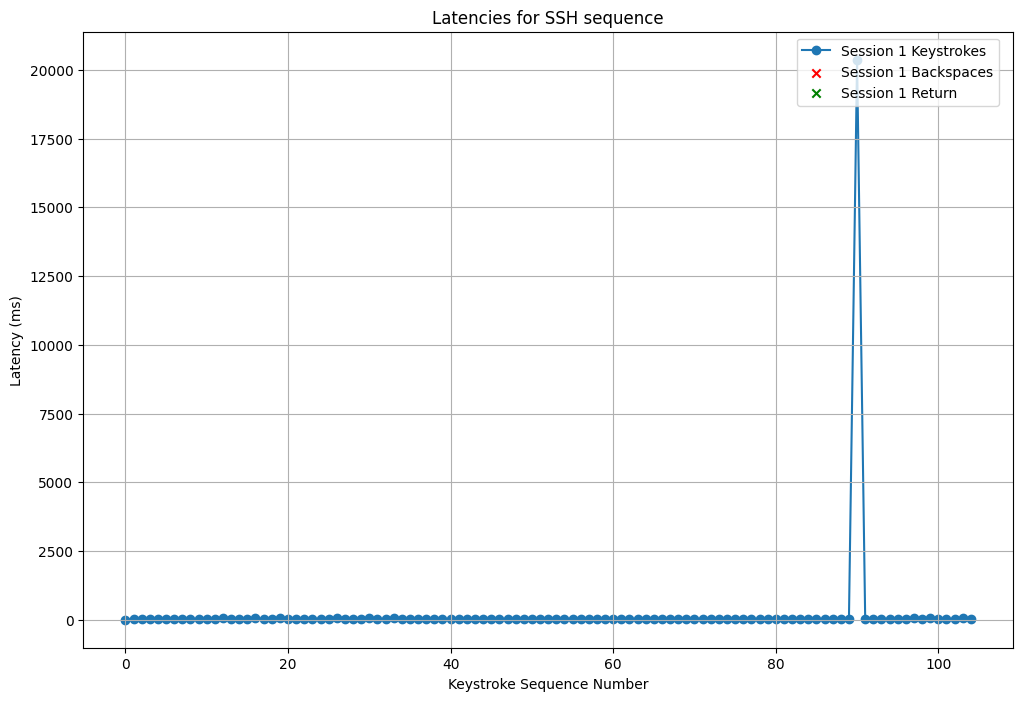

In [26]:
plot_ssh_latency(patch3[0])

So, what is this spike? Let's see what happens if we omit the spike, as well as everything after it.

In [88]:
import matplotlib
from matplotlib import pyplot as plt

In [94]:
def plot_ssh_latency(sequence):
    """
    Plots SSH keystrokes (unlabelled).

    Y-Axis: Latency (ms)
    X-Axis: Keystroke ID
    """
    #plt.figure(figsize=(12, 8))
    plt.figure().set_size_inches(w=6.30045, h=3.6)
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'])
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'])
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'])
                
    # Regular Keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Backspaces 
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    # Return (Enter)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(.6,1), loc='upper left')
    plt.grid(True)
    plt.show()
    plt.savefig("/tmp/figure.pgf")

In [95]:
plot_ssh_latency(patch3[0][:-15])

/tmp/ipykernel_118636/2020340058.py:38: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


Suddenly, we get a much clearer picture. And alas, we spot six further spikes. 

Combined with the initial keystroke at `0`, this means we observe seven keystrokes, which could well be the letters of `uptime`, plus the `Return`. 

### patch4.pcapng

Again, we ran `uptime`, followed by `exit`. After typing out `uptime` normally, however, we paused and waited for the `chaff` keystrokes to subside, such that our Return could be spotted more easily by `SSHniff`. 

In [28]:
patch4 = load_ssh_session("./sshniff_output/patch4_uptime_delayed_enter_exit_sessions.json", 2)

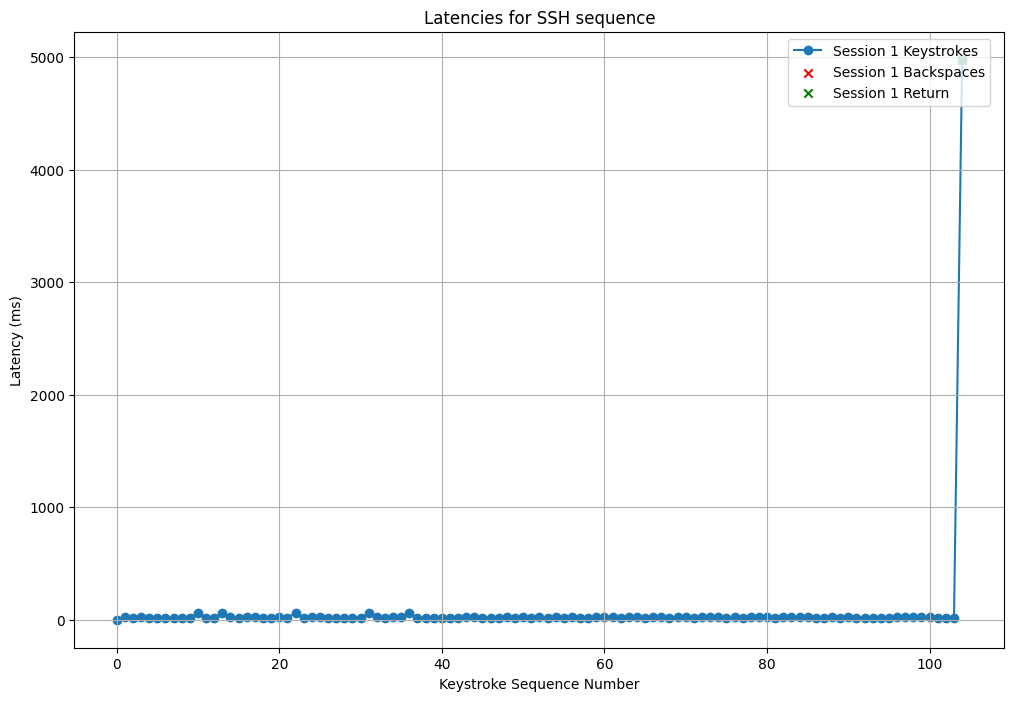

In [29]:
plot_ssh_latency(patch4[0])

Again, we see a spike, but this time at the end of the capture, and correctly classified as the `Return` keystroke. So, now that we have narrowed down where the command ends, let's see what happens if we once more omit the spike and focus on the rest.

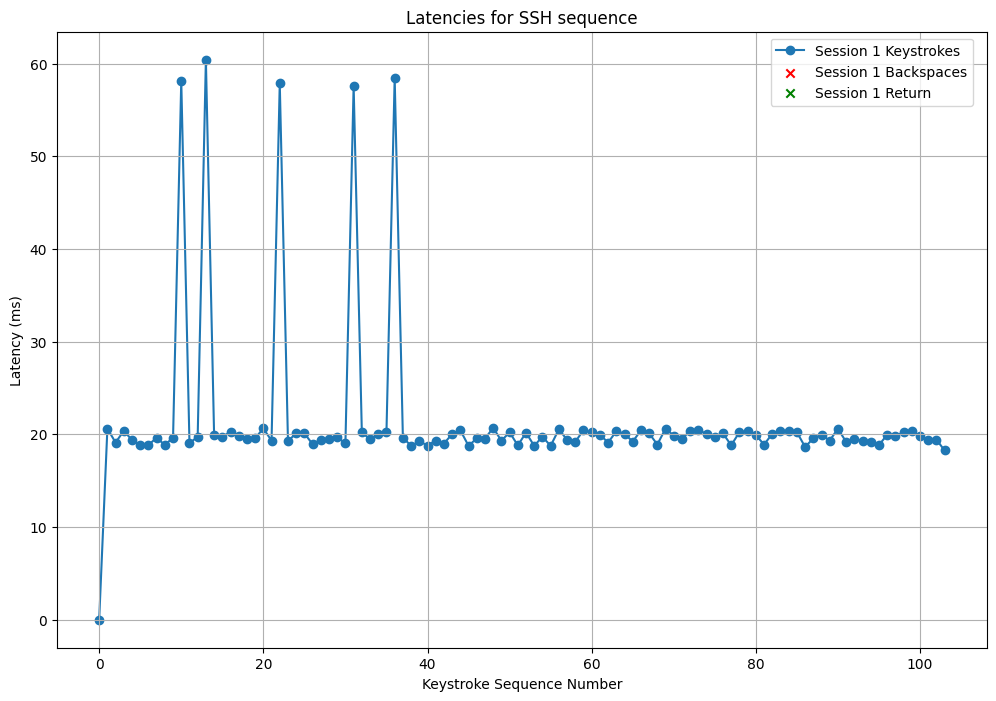

In [39]:
plot_ssh_latency(patch4[0][:-1])

We see five happy spikes, which together with the initial keystroke at `0` could make up the six keystrokes in `uptime`.

### patch5.pcapng

This time, we ran a longer command: `netstat -tlpn`. Again, we waited for the `chaff` to stop before executing it. 

> Note that this delay should not be seen as an unrealistic "advantage", as it is merely done to make it easier for `SSHniff` to delimit a sequence. Browsing the `Wireshark` output still shows that the return can be fished out, however, that is left for future versions of the tool. 

In [40]:
patch5 = load_ssh_session("./sshniff_output/patch5_netstat_tlpn_delay_exit_sessions.json", 0)

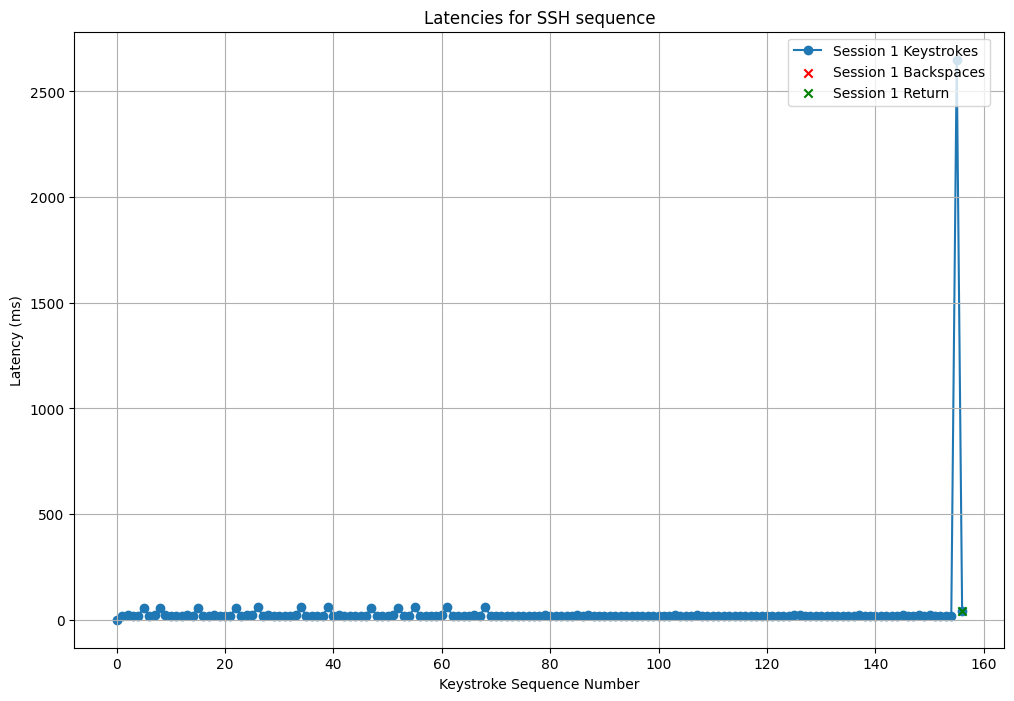

In [41]:
plot_ssh_latency(patch5[0])

The spike is back, although likely due to `SSHniff`'s sorting, the Return key is identified as one after the spike. 

Once again, let's see what happens if we ignore it:

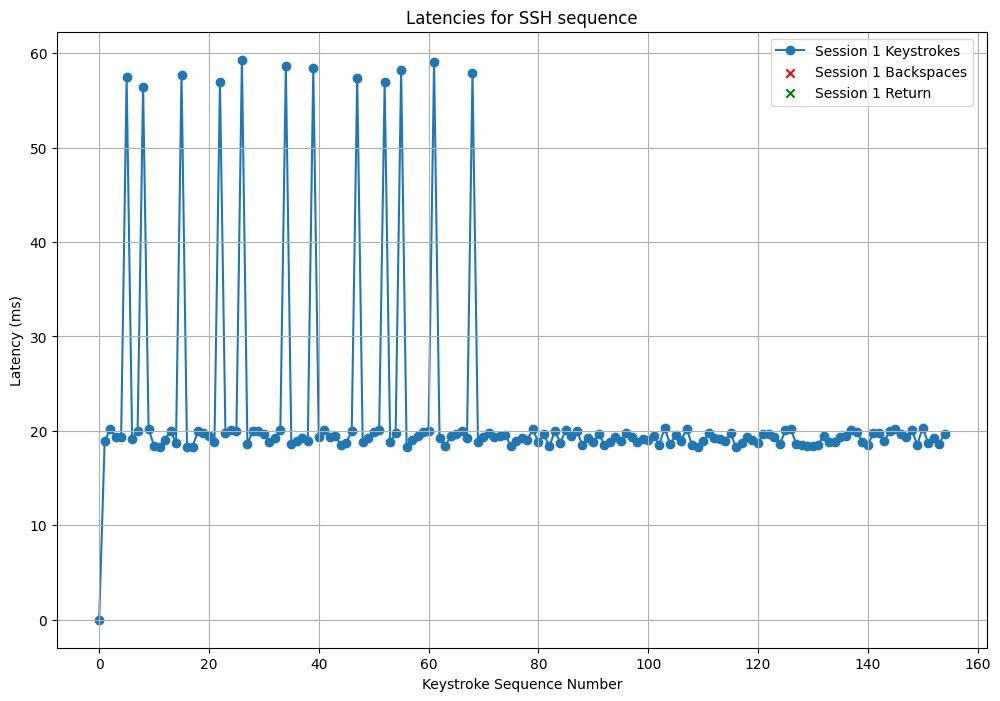

In [42]:
plot_ssh_latency(patch5[0][:-2])

Twelve spikes emerge, plus one guaranteed authentic keystroke at `0`, make thirteen; fitting the letters for `netstat -tlpn`. 

Eagle-eyed readers will have noticed that the spikes all seem to hover around the 60ms mark, as opposed to the fake (?) keystrokes, which hover around 20ms (as per the current 20ms default).

Initially, I thought this is was because the real keystrokes are still quantised to the next nearest interval, so we won't see our typical spikes in the hundreds of ms ranges. However, looking through the Wireshark packets I came to realise that this assumption is wrong. 

The reason for the neatly-sized spikes is because our `SSHniff` implementation is **missing** packets. The tool, by design, looks for packets of a certain keystroke size `k`. While there are some variences to this size `k` that are explained in detail in the documentation, the tool generally ignores anything falling out of that range- as it should. This patch, however, seems to have an interesting effect on how the real keystroke packets are bunched together. Crucially, it is evident that the true packets in the body of a sequence are actually bunched into a slightly larger packet, which also triggers **two** server echo responses (of size `k`). So, `SSHniff` passes by these obscure packets and moves to the next one that fits the keystroke profile. As such, we can see that for each real letter (except the first), we skip **three** packets (CTS, echo,echo), which are the actual **true** keystroke and server echoes. This explains why our spikes hover at 60ms; not because they are quantised to do so, but because the latencies are computed relative to the last "Keystroke", ignoring the non-keystroke-sized packets; three missing packets cause a 60ms (3\*20ms) gap, hence, the spikes. 

Additionally, this begs the question of whether the 20ms packet spam is required, given that the real keystrokes still poke out substantially. As for the trailing `chaff`, it does seem to complicate spotting the `Return` keystroke, but only if the server's ouput is neatly packaged into these smaller, near-keystroke-size packets. Large consecutive STC packets will still stick out and therefore also render the `chaff` ineffective.

In order to analyse this, we will need to tweak `SSHniff` a bit. First, we will jot down the `tcp.seq` number of each of the suspected real keystrokes, here. Then, we will compile a version of `SSHniff` without the call to `make_relative()`, in the `process_keystrokes()` function. This will leave the keystrokes' `timestamp` value as a UNIX timestamp, which we will use here to find the true latency behind the suspected keystrokes. 

We will use `patch4`, where we ran `uptime`, since `uptime` seems to be matched quite well using DTW. 

In [67]:
# `tcp.seq` of the spikes 
spikes = [patch4[0][0]['seq']]
spikes.extend([keystroke['seq'] for keystroke in patch4[0] if keystroke['timestamp'] > 50])
print(spikes)

[4450, 4918, 5134, 5566, 5998, 6286, 8770]


In [89]:
patch4_v2 = load_ssh_session("./sshniff_output/patch4_v2_sessions.json", 2)
# `load_ssh_session` converts microseconds to milliseconds, but since this capture contains the true
# UNIX timestamps and not relative intervals, we undo the conversion.
for sequence in patch4_v2:
    for keystroke in sequence:
        keystroke['timestamp'] = int(keystroke['timestamp'] * 1000)

Now that we have loaded the keystrokes with their UNIX timestamps, we will load the spikes again, via their `tcp.seq` value.

In [90]:
suspects = [keystroke for keystroke in patch4_v2[0] if keystroke['seq'] in spikes]
print(len(suspects))

7


Now we make them relative to one another.

In [91]:
prev_time = suspects[0]['timestamp']
for keystroke in suspects[1:]:
    tmp = keystroke['timestamp']
    keystroke['timestamp'] = tmp - prev_time
    prev_time = tmp
suspects[0]['timestamp'] = 0

In [92]:
# Convert to ms
for keystroke in suspects:
    keystroke['timestamp'] = int(keystroke['timestamp'] / 1000)

In [93]:
suspects

[{'k_type': 'Keystroke', 'timestamp': 0, 'response_size': None, 'seq': 4450},
 {'k_type': 'Keystroke', 'timestamp': 233, 'response_size': None, 'seq': 4918},
 {'k_type': 'Keystroke', 'timestamp': 99, 'response_size': None, 'seq': 5134},
 {'k_type': 'Keystroke', 'timestamp': 216, 'response_size': None, 'seq': 5566},
 {'k_type': 'Keystroke', 'timestamp': 213, 'response_size': None, 'seq': 5998},
 {'k_type': 'Keystroke', 'timestamp': 138, 'response_size': None, 'seq': 6286},
 {'k_type': 'Enter', 'timestamp': 6297, 'response_size': 208, 'seq': 8770}]

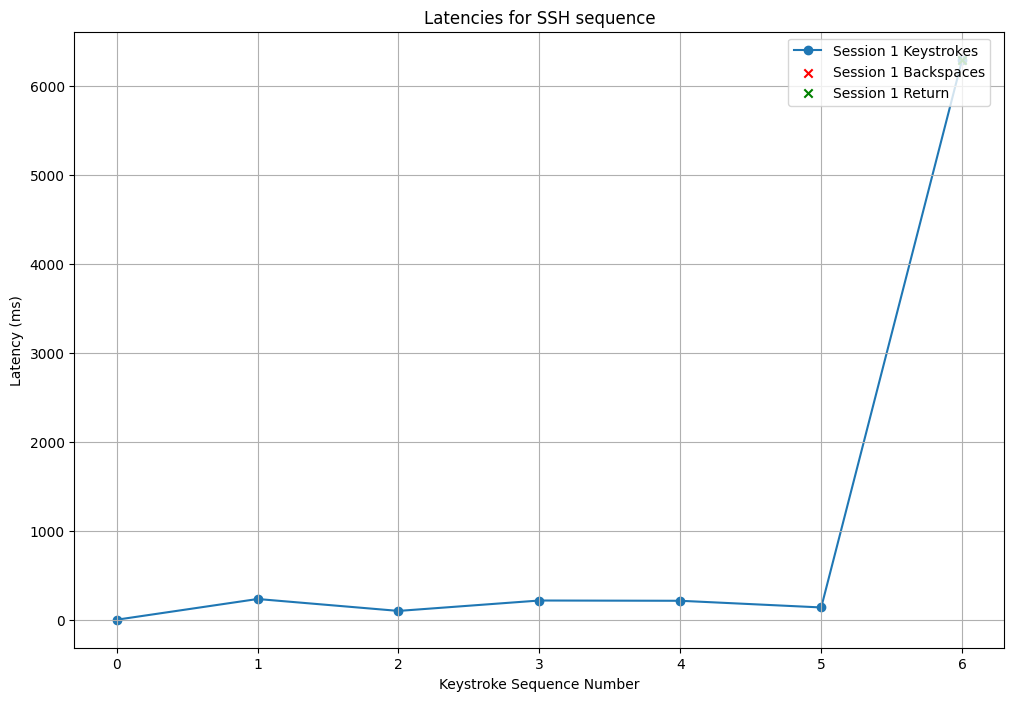

In [96]:
plot_ssh_latency(suspects)

And now, for the grand finale, let's see if DTW can match our suspects to a command...

In [98]:
find_best_match(suspects[:-1], cmds)

[('uptime', 0.27878810170614754),
 ('exit', 0.31296862209671183),
 ('sudo su', 0.42893768469971527),
 ('sudo', 0.4548670303909148),
 ('ss -tuln', 0.4800677905681097),
 ('nano ', 0.4838635763664617),
 ('whoami', 0.541249649640377),
 ('wget https://', 0.5476808542168505),
 ('touch ', 0.5577089715936769),
 ('vim ', 0.5941837255785937),
 ('curl http://', 0.6098441527552824),
 ('cat /etc/hosts', 0.6373539803555923),
 ('mv * ../', 0.6376433801343455),
 ('df -hT /', 0.6864805503495429),
 ('id', 0.713918536867261),
 ('cd', 0.7211846763854547),
 ('tar --help', 0.7220438265253709),
 ('cat /etc/resolv.conf', 0.7660279571485128),
 ('ping -c 1 9.9.9.9', 0.7880297000657951),
 ('tail /var/log/syslog', 0.8058164923537648),
 ('sudo apt update', 0.8173253948665636),
 ('cat /etc/passwd', 0.8509171648424856),
 ('rm -rf /tmp/*', 0.8564622457015545),
 ('sudo apt upgrade ', 0.9690784549492492)]

It sure does. We ran `uptime` in `patch4`, and with a little tweaking of `SSHniff` we see that we can still match the command in the same exact fashion as before. Also, note that strictly speaking we did not use the precise keystroke packet, since, as stated, their different sizing is both what sets them apart and also causes `SSHniff` to pass them by. However, it's this exact bypass of three packets per real keystroke that caused the spikes in the first place and drew our attention to this dubious behaviour. And since those real keystrokes are all offset by the same amount, DTW has no problem matching that offset to the profile of the real command. 

> Note: This test was ran with `ChaCha20-Poly1305@openssh.com`, but the same exact pattern was verified on the GCM ciphers, as well.